In [1]:
import tensorflow as tf
import requests
print(tf.__version__)
import zipfile
import requests
import os

2.1.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        print("Couldn't set memory_growth")
        pass

In [10]:
# Retrieve the data
if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')

    with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
    
    with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("The file already exists.")

The file already exists.


## Read the label information of the data

In [11]:
import pandas as pd

data_dir = os.path.join('data', 'tiny-imagenet-200')
wnids_path = os.path.join(data_dir, 'wnids.txt')
words_path = os.path.join(data_dir, 'words.txt')

def get_tiny_imagenet_classes(wnids_path, words_path):
    wnids = pd.read_csv(wnids_path, header=None, squeeze=True)
    words = pd.read_csv(words_path, sep='\t', index_col=0, header=None)
    words_200 = words.loc[wnids].rename({1:'class'}, axis=1)
    words_200.index.name = 'wnid'
    return words_200.reset_index()

labels = get_tiny_imagenet_classes(wnids_path, words_path)
labels.head(n=25)

,wnid,class
0,n02124075,Egyptian cat
1,n04067472,reel
2,n04540053,volleyball
3,n04099969,"rocking chair, rocker"
4,n07749582,lemon
5,n01641577,"bullfrog, Rana catesbeiana"
6,n02802426,basketball
7,n09246464,"cliff, drop, drop-off"
8,n07920052,espresso
9,n03970156,"plunger, plumber's helper"


## Find out how many training instances for each class are there?

In [12]:
def get_image_count(data_dir):    
    return len([f for f in os.listdir(data_dir) if f.lower().endswith('jpeg')])
    
labels["n_train"] = labels["wnid"].apply(lambda x: get_image_count(os.path.join(data_dir, 'train', x, 'images')))
labels.head()

,wnid,class,n_train
0,n02124075,Egyptian cat,400
1,n04067472,reel,400
2,n04540053,volleyball,400
3,n04099969,"rocking chair, rocker",400
4,n07749582,lemon,400


## Look at summary statistics of the `n_train` column

In [13]:
labels["n_train"].describe()

count    200.0
mean     400.0
std        0.0
min      400.0
25%      400.0
50%      400.0
75%      400.0
max      400.0
Name: n_train, dtype: float64

## Separating a validation set

In [34]:
import random
import shutil
seed=4321
random.seed(seed)

def create_validation_set(src_dir, dst_dir, validation_split=0.2):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    for f in os.listdir(src_dir):        
        if os.path.isdir(os.path.join(src_dir,f)):                 
            sub_dir = os.path.join(src_dir, f, 'images')                        
            target_sub_dir = os.path.join(dst_dir, f, 'images')
            if not os.path.exists(target_sub_dir):
                os.makedirs(target_sub_dir)
                            
            sub_images = [os.path.join(sub_dir, ff) for ff in os.listdir(sub_dir) if ff.lower().endswith('jpeg')]
            val_images = random.sample(sub_images, int(len(sub_images)*validation_split))
            for vimg in val_images:
                shutil.move(vimg, target_sub_dir)

create_validation_set(
    os.path.join('data','tiny-imagenet-200', 'train'), 
    os.path.join('data','tiny-imagenet-200', 'train_val'), 
    0.2)

In [40]:
labels["n_train_2"] = labels["wnid"].apply(lambda x: get_image_count(os.path.join(data_dir, 'train', x, 'images')))
labels["n_train_val"] = labels["wnid"].apply(lambda x: get_image_count(os.path.join(data_dir, 'train_val', x, 'images')))
labels.head()

,wnid,class,n_train,n_train_2,n_train_val
0,n02124075,Egyptian cat,400,400,100
1,n04067472,reel,400,400,100
2,n04540053,volleyball,400,400,100
3,n04099969,"rocking chair, rocker",400,400,100
4,n07749582,lemon,400,400,100


In [ ]:
## Inception v1 network

## init defaults to glorot_uniform

In [48]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Concatenate, Flatten, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K

def inception_v1():
    
    K.clear_session()
    def inception(inp, n_filters):

        # 1x1 layer
        out1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)

        # 1x1 followed by 3x3
        out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)
        out2_2 = Conv2D(n_filters[1][1], (3,3), strides=(1,1), activation='relu', padding='same')(out2_1)

        # 1x1 followed by 5x5
        out3_1 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation='relu', padding='same')(inp)
        out3_2 = Conv2D(n_filters[2][1], (5,5), strides=(1,1), activation='relu', padding='same')(out3_1)

        # 3x3 (pool) followed by 1x1
        out4_1 = MaxPool2D((3,3), strides=(1,1), padding='same')(inp)
        out4_2 = Conv2D(n_filters[3][0], (1,1), strides=(1,1), activation='relu', padding='same')(out4_1)

        out = Concatenate(axis=-1)([out1, out2_2, out3_2, out4_2])
        return out

    def aux_out(inp,name=None):    
        maxpool1 = AvgPool2D((5,5), strides=(1,1), padding='same')(inp)
        conv1 = Conv2D(128, (1,1), activation='relu', padding='same')(maxpool1)
        flat = Flatten()(conv1)
        dense1 = Dense(1024, activation='relu')(flat)    
        dropout1 = Dropout(0.7)(dense1)
        aux_out = Dense(200, activation='softmax', name=name)(dropout1)
        return aux_out

    inp = Input(shape=(64,64,3))
    conv1 = Conv2D(64, (7,7), strides=(2,2), activation='relu', padding='same')(inp)
    lrn1 = Lambda(lambda x: tf.nn.local_response_normalization(x))(conv1)

    conv2 = Conv2D(64, (1,1), strides=(1,1), padding='same')(lrn1)
    conv3 = Conv2D(192, (3,3), strides=(1,1), activation='relu', padding='same')(conv2)
    lrn2 = Lambda(lambda x: tf.nn.local_response_normalization(x))(conv3)
    maxpool2 = MaxPool2D((3,3), strides=(2,2), padding='same')(lrn2)

    inc_3a = inception(maxpool2, [(64,),(96,128),(16,32),(32,)])
    inc_3b = inception(inc_3a, [(128,),(128,192),(32,96),(64,)])

    maxpool2 = MaxPool2D((3,3), strides=(2,2), padding='same')(inc_3b)

    inc_4a = inception(maxpool2, [(192,),(96,208),(16,48),(64,)])
    inc_4b = inception(inc_4a, [(160,),(112,224),(24,64),(64,)])

    aux_out1 = aux_out(inc_4a, name='aux1')

    inc_4c = inception(inc_4b, [(128,),(128,256),(24,64),(64,)])
    inc_4d = inception(inc_4c, [(112,),(144,288),(32,64),(64,)])
    inc_4e = inception(inc_4d, [(256,),(160,320),(32,128),(128,)])

    aux_out2 = aux_out(inc_4d, name='aux2')

    inc_5a = inception(inc_4e, [(256,),(160,320),(32,128),(128,)])
    inc_5b = inception(inc_5a, [(384,),(192,384),(48,128),(128,)])
    avgpool1 = AvgPool2D((8,8), strides=(1,1), padding='valid')(inc_5b)

    flat_out = Flatten()(avgpool1)
    dropout1 = Dropout(0.4)(flat_out)
    out_main = Dense(200, activation='softmax', name='final')(dropout1)

    # Loss Weighing: https://github.com/tensorflow/models/blob/09d3c74a31d7e0c1742ae65025c249609b3c9d81/research/slim/train_image_classifier.py#L495
    model = Model(inputs=inp, outputs=[out_main, aux_out1, aux_out2])
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], 
                       optimizer='adam', loss_weights=[1.0, 0.4, 0.4], metrics=['accuracy'])
    return model

model = inception_v1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   4160        lambda[0][0]                     
______________________________________________________________________________________________

In [36]:
print(minception.metrics_names)

['loss', 'final_loss', 'aux1_loss', 'aux2_loss', 'final_accuracy', 'aux1_accuracy', 'aux2_accuracy']


In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

random_seed = 4321
batch_size = 128
image_gen = ImageDataGenerator(samplewise_center=True)

train_gen = image_gen.flow_from_directory(
    os.path.join('data','tiny-imagenet-200', 'train'), target_size=(64, 64), classes=None,
    class_mode='categorical', batch_size=batch_size, shuffle=True, seed=random_seed
)
valid_gen = image_gen.flow_from_directory(
    os.path.join('data','tiny-imagenet-200',  'train_val'), target_size=(64, 64), classes=None,
    class_mode='categorical', batch_size=batch_size, shuffle=False, seed=random_seed
)

def data_gen_aux(gen):
    for x,y in gen:
        yield x,(y,y,y)
        
train_gen_aux = data_gen_aux(train_gen)
valid_gen_aux = data_gen_aux(valid_gen)


Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.


In [38]:
#image_gen.class_indices

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import time
if not os.path.exists('eval'):
    os.mkdir('eval')
    
csv_logger = CSVLogger(os.path.join('eval','1_eval_base.log'))


t1 = time.time()
history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=int(0.8*(500*200)/batch_size), validation_steps=int(0.2*(500*200)/batch_size),
    epochs=30, callbacks=[csv_logger]
)
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

Train for 625 steps, validate for 156 steps
Epoch 1/30
625/625 [==============================] - 132s 211ms/step - loss: 9.2323 - final_loss: 5.1382 - aux1_loss: 5.0990 - aux2_loss: 5.1363 - final_accuracy: 0.0111 - aux1_accuracy: 0.0152 - aux2_accuracy: 0.0121 - val_loss: 8.7514 - val_final_loss: 4.8837 - val_aux1_loss: 4.7907 - val_aux2_loss: 4.8786 - val_final_accuracy: 0.0249 - val_aux1_accuracy: 0.0367 - val_aux2_accuracy: 0.0280
Epoch 2/30
625/625 [==============================] - 130s 209ms/step - loss: 8.4607 - final_loss: 4.6992 - aux1_loss: 4.6574 - aux2_loss: 4.7464 - final_accuracy: 0.0369 - aux1_accuracy: 0.0467 - aux2_accuracy: 0.0348 - val_loss: 7.9350 - val_final_loss: 4.4407 - val_aux1_loss: 4.3076 - val_aux2_loss: 4.4283 - val_final_accuracy: 0.0610 - val_aux1_accuracy: 0.0871 - val_aux2_accuracy: 0.0630
Epoch 3/30
625/625 [==============================] - 132s 211ms/step - loss: 7.8060 - final_loss: 4.3223 - aux1_loss: 4.3094 - aux2_loss: 4.3997 - final_accuracy: 

Epoch 22/30
625/625 [==============================] - 128s 206ms/step - loss: 3.8989 - final_loss: 1.8814 - aux1_loss: 2.6540 - aux2_loss: 2.3898 - final_accuracy: 0.4999 - aux1_accuracy: 0.3408 - aux2_accuracy: 0.3905 - val_loss: 6.2919 - val_final_loss: 3.5386 - val_aux1_loss: 3.3625 - val_aux2_loss: 3.5207 - val_final_accuracy: 0.2776 - val_aux1_accuracy: 0.2655 - val_aux2_accuracy: 0.2580
Epoch 23/30
625/625 [==============================] - 128s 206ms/step - loss: 3.7810 - final_loss: 1.8055 - aux1_loss: 2.6107 - aux2_loss: 2.3279 - final_accuracy: 0.5160 - aux1_accuracy: 0.3462 - aux2_accuracy: 0.4026 - val_loss: 6.3243 - val_final_loss: 3.5419 - val_aux1_loss: 3.3862 - val_aux2_loss: 3.5699 - val_final_accuracy: 0.2776 - val_aux1_accuracy: 0.2651 - val_aux2_accuracy: 0.2570
Epoch 24/30
625/625 [==============================] - 129s 206ms/step - loss: 3.6947 - final_loss: 1.7476 - aux1_loss: 2.5833 - aux2_loss: 2.2844 - final_accuracy: 0.5299 - aux1_accuracy: 0.3514 - aux2_acc

In [40]:
if not os.path.exists('models'):
    os.mkdir("models")
model.save(os.path.join('models', 'inception_v1_base.h5'))

## Data augmentation and early stopping

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

random_seed = 4321
batch_size = 128
train_gen = ImageDataGenerator(
    samplewise_center=True, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, brightness_range=(0.5,1.5), shear_range=5, zoom_range=0.2, horizontal_flip=True
).flow_from_directory(
    os.path.join('data','tiny-imagenet-200', 'train'), target_size=(64, 64), classes=None,
    class_mode='categorical', batch_size=batch_size, shuffle=True, seed=random_seed
)

valid_gen = ImageDataGenerator(samplewise_center=True).flow_from_directory(
    os.path.join('data','tiny-imagenet-200',  'train_val'), target_size=(64, 64), classes=None,
    class_mode='categorical', batch_size=batch_size, shuffle=False, seed=random_seed
)

def data_gen_aux(gen):
    for x,y in gen:
        yield x,(y,y,y)
        
train_gen_aux = data_gen_aux(train_gen)
valid_gen_aux = data_gen_aux(valid_gen)


Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.


## Verify train data is augmented and validation data is not.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

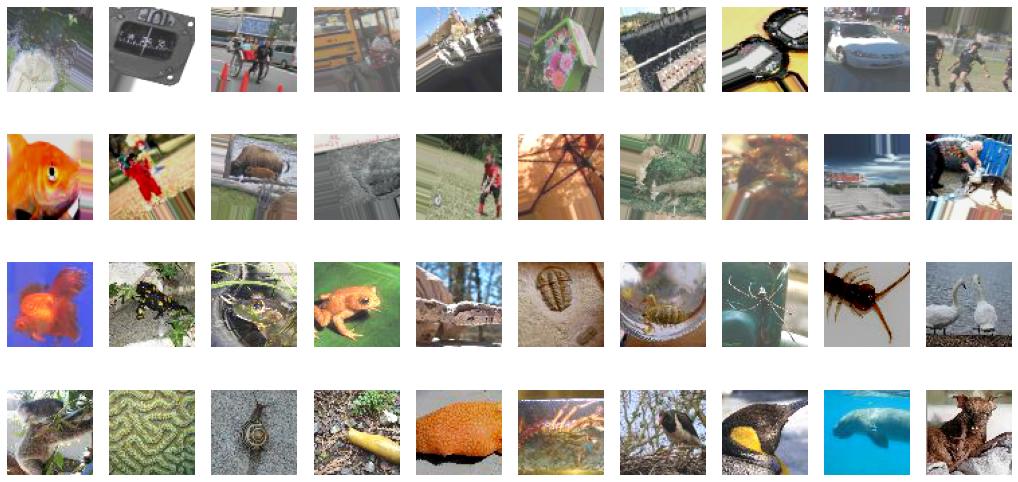

In [45]:
import numpy as np
i=0
data = []
for x,y in train_gen:
    if i>=20: break
    data.append((x[0,:,:,:]+128).astype('int32'))
    #print(np.min(x[0,:,:,:]), np.max(x[0,:,:,:]))
    i += 1
    
i=0
for x,y in valid_gen:
    if i>=20: break
    data.append((x[0,:,:,:]+128).astype('int32'))
    i += 1
    
import matplotlib.pyplot as plt
%matplotlib inline


n_rows = 4
n_cols = 10
f, axes = plt.subplots(n_rows, n_cols, figsize=(18,9))

for ri in range(n_rows):
    for ci in range(n_cols):
        i = ri*n_cols + ci
        axes[ri][ci].imshow(data[i])
        axes[ri][ci].axis('off')

In [49]:
model = inception_v1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   4160        lambda[0][0]                     
______________________________________________________________________________________________

In [50]:
import time
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

es_callback = EarlyStopping(monitor='val_loss', patience=5)
csv_logger = CSVLogger(os.path.join('eval','2_eval_data_aug_early_stopping.log'))

t1 = time.time()
history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=int(0.8*(500*200)/batch_size), validation_steps=int(0.2*(500*200)/batch_size),
    epochs=30, callbacks=[es_callback, csv_logger]
)
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

Train for 625 steps, validate for 156 steps
Epoch 1/30
625/625 [==============================] - 133s 212ms/step - loss: 9.3246 - final_loss: 5.1852 - aux1_loss: 5.1555 - aux2_loss: 5.1929 - final_accuracy: 0.0085 - aux1_accuracy: 0.0120 - aux2_accuracy: 0.0087 - val_loss: 9.0314 - val_final_loss: 5.0301 - val_aux1_loss: 4.9399 - val_aux2_loss: 5.0635 - val_final_accuracy: 0.0170 - val_aux1_accuracy: 0.0278 - val_aux2_accuracy: 0.0170
Epoch 2/30
625/625 [==============================] - 129s 206ms/step - loss: 8.8967 - final_loss: 4.9369 - aux1_loss: 4.9129 - aux2_loss: 4.9866 - final_accuracy: 0.0242 - aux1_accuracy: 0.0281 - aux2_accuracy: 0.0214 - val_loss: 8.5246 - val_final_loss: 4.7470 - val_aux1_loss: 4.6692 - val_aux2_loss: 4.7746 - val_final_accuracy: 0.0382 - val_aux1_accuracy: 0.0525 - val_aux2_accuracy: 0.0373
Epoch 3/30
625/625 [==============================] - 130s 207ms/step - loss: 8.5057 - final_loss: 4.7060 - aux1_loss: 4.7122 - aux2_loss: 4.7870 - final_accuracy: 

In [51]:
if not os.path.exists('models'):
    os.mkdir("models")
minception.save(os.path.join('models', 'inception_v1_data_aug_early_stopping.h5'))

## MInception Resnet v2

http://cs231n.stanford.edu/reports/2017/pdfs/930.pdf

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, AvgPool2D, Dense, Concatenate, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K

K.clear_session()
def get_minception_resnet_v2():
    
    def inception_resnet_b(inp, n_filters, initializer, activation='relu', bn=True, res_w=0.1):
        out1_1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
        
        out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
        out2_2 = Conv2D(n_filters[1][1], (1,7), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out2_1)
        if bn:
            out2_2 = BatchNormalization()(out2_2)
        out2_3 = Conv2D(n_filters[1][2], (7,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out2_2)
        if bn:
            out2_3 = BatchNormalization()(out2_3)
        
        out3_1 = Concatenate(axis=-1)([out1_1, out2_3])
        out3_2 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out3_1)
        if bn:
            out3_2 = BatchNormalization()(out3_2)
        
        out3_2 += res_w * inp
        
        return out3_2
    
    def inception_resnet_a(inp, n_filters, initializer, activation='relu', bn=True, res_w=1.0):
        out1_1 = Conv2D(n_filters[0][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
            
        out2_1 = Conv2D(n_filters[1][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
        out2_2 = Conv2D(n_filters[1][1], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out2_1)
        if bn:
            out2_2 = BatchNormalization()(out2_2)
        out2_3 = Conv2D(n_filters[1][2], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out2_2)
        if bn:
            out2_3 = BatchNormalization()(out2_3)
        
        out3_1 = Conv2D(n_filters[2][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out3_1 = BatchNormalization()(out3_1)
        out3_2 = Conv2D(n_filters[2][1], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out3_1)
        if bn:
            out3_2 = BatchNormalization()(out3_2)
        out3_3 = Conv2D(n_filters[2][2], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out3_2)
        if bn:
            out3_3 = BatchNormalization()(out3_3)
        out3_4 = Conv2D(n_filters[2][3], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out3_3)
        if bn:
            out3_4 = BatchNormalization()(out3_4)
            
        out4_1 = Concatenate(axis=-1)([out1_1, out2_3, out3_4])
        out4_2 = Conv2D(n_filters[3][0], (1,1), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out4_1)
        if bn:
            out4_2 = BatchNormalization()(out4_2)
        
        out4_2 += res_w * inp
        
        return out4_2
        
    def reduction(inp, n_filters, initializer, activation='relu', bn=True):
        
        out1_1 = Conv2D(n_filters[0][0], (3,3), strides=(2,2), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out1_1 = BatchNormalization()(out1_1)
        out1_2 = Conv2D(n_filters[0][1], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out1_1)
        if bn:
            out1_2 = BatchNormalization()(out1_2)
        out1_3 = Conv2D(n_filters[0][2], (3,3), strides=(1,1), activation=activation, 
                        kernel_initializer=initializer, padding='same')(out1_2)
        if bn:
            out1_3 = BatchNormalization()(out1_3)
            
        out2_1 = Conv2D(n_filters[1][0], (3,3), strides=(2,2), activation=activation, 
                        kernel_initializer=initializer, padding='same')(inp)
        if bn:
            out2_1 = BatchNormalization()(out2_1)
            
        out3_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(inp)
        
        out = Concatenate(axis=-1)([out1_3, out2_1, out3_1])        
        
        return out    
        
    activation='relu'
    init = tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in')
    
    bn=True
    inp = Input(shape=(56,56,3))
    # 7x7 convolution
    conv1_1 = Conv2D(32, (3,3), strides=(2,2), activation=activation, kernel_initializer=init, padding='same')(inp) #62x62
    if bn:
        conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(32, (3,3), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv1_1) # 31x31
    if bn:
        conv1_2 = BatchNormalization()(conv1_2)
    conv1_3 = Conv2D(64, (3,3), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv1_2) # 31x31
    if bn:
        conv1_3 = BatchNormalization()(conv1_3)
        
    maxpool2_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(conv1_3)
    conv2_2 = Conv2D(96, (3,3), strides=(2,2), activation=activation, kernel_initializer=init, padding='same')(conv1_3)
    if bn:
        conv2_2 = BatchNormalization()(conv2_2)
    out2 = Concatenate(axis=-1)([maxpool2_1, conv2_2])
    
    conv3_1 = Conv2D(64, (1,1), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(out2)
    if bn:
        conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(96, (3,3), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv3_1)
    if bn:
        conv3_2 = BatchNormalization()(conv3_2)
    conv4_1 = Conv2D(64, (1,1), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(out2)
    if bn:
        conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(64, (7,1), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv4_1)
    if bn:
        conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(64, (1,7), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv4_2)
    if bn:
        conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(96, (3,3), strides=(1,1), activation=activation, kernel_initializer=init, padding='same')(conv4_3)
    if bn:
        conv4_4 = BatchNormalization()(conv4_4)
        
    out34 = Concatenate(axis=-1)([conv3_2, conv4_4])
    
    maxpool5_1 = MaxPool2D((3,3), strides=(2,2), padding='same')(out34)
    conv6_1 = Conv2D(192, (3,3), strides=(2,2), activation=activation, kernel_initializer=init, padding='same')(out34)
    
    out56 = Concatenate(axis=-1)([maxpool5_1, conv6_1])
    
    inc_a = inception_resnet_a(out56, [(32,),(32,32,384), (32, 48, 64, 384),(384,)], initializer=init)
    
    red = reduction(inc_a, [(256,256,384),(384,)], initializer=init)
    
    inc_b1 = inception_resnet_b(red, [(192,),(128,160,192),(1152,)], initializer=init)
    inc_b2 = inception_resnet_b(inc_b1,  [(192,),(128,160,192),(1152,)], initializer=init)
    
    avgpool1 = AvgPool2D((4,4), strides=(1,1), padding='valid')(inc_b2)
    flat_out = Flatten()(avgpool1)
    dropout1 = Dropout(0.5)(flat_out)
    out_main = Dense(200, activation='softmax',  kernel_initializer=init, name='final')(flat_out)

    # Loss Weighing: https://github.com/tensorflow/models/blob/09d3c74a31d7e0c1742ae65025c249609b3c9d81/research/slim/train_image_classifier.py#L495
    minception_resnet_v2 = Model(inputs=inp, outputs=out_main)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
    minception_resnet_v2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return minception_resnet_v2

model = get_minception_resnet_v2()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

random_seed = 4321
np.random.seed(random_seed)

batch_size = 128
train_gen = ImageDataGenerator(
    samplewise_center=False, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, brightness_range=(0.5,1.5), shear_range=5, zoom_range=0.2, horizontal_flip=True
).flow_from_directory(
    os.path.join('data','tiny-imagenet-200', 'train'), target_size=(64, 64), classes=None,
    class_mode='categorical', batch_size=batch_size, shuffle=True, seed=random_seed
)

valid_gen = ImageDataGenerator(samplewise_center=False).flow_from_directory(
    os.path.join('data','tiny-imagenet-200',  'train_val'), target_size=(64, 64), classes=None,
    class_mode='categorical', batch_size=batch_size, shuffle=False, seed=random_seed
)

def data_gen_crop(gen, crop_size, crop_center=True, random_gamma=False):
    for x,y in gen:
        if crop_center:
            start_h = (x.shape[1]-crop_size[0])//2
            start_w = (x.shape[2]-crop_size[1])//2                 
        else:
            start_h = np.random.randint(0, (x.shape[1]-crop_size[0])//2)
            start_w = np.random.randint(0, (x.shape[2]-crop_size[1])//2)        
            
        x = x[:,start_h:start_h+crop_size[0], start_w:start_w+crop_size[1], :]        
        
        if random_gamma:
            x = tf.image.adjust_gamma(x, gamma=np.random.uniform(0.9, 1.08), gain=1)
        
        x -= np.mean(x, axis=(1,2), keepdims=True)
        yield x,y
        
train_gen_aux = data_gen_crop(train_gen, (56,56), crop_center=False, random_gamma=True)
valid_gen_aux = data_gen_crop(valid_gen, (56, 56), crop_center=True)



Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.


In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from functools import partial

es_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger(os.path.join('eval','3_eval_minception.log'))
n_epochs=50
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
)

t1 = time.time()
history = model.fit(
    train_gen_aux, validation_data=valid_gen_aux, 
    steps_per_epoch=int(0.8*(500*200)/batch_size), validation_steps=int(0.2*(500*200)/batch_size),
    epochs=n_epochs, callbacks=[es_callback, csv_logger, lr_callback]
)
t2 = time.time()

print("It took {} seconds to complete the training".format(t2-t1))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625 steps, validate for 156 steps
Epoch 1/50
625/625 [==============================] - 104s 167ms/step - loss: 4.7974 - accuracy: 0.0521 - val_loss: 4.8362 - val_accuracy: 0.0619
Epoch 2/50
625/625 [==============================] - 101s 161ms/step - loss: 4.1960 - accuracy: 0.1168 - val_loss: 4.3583 - val_accuracy: 0.1098
Epoch 3/50
625/625 [==============================] - 101s 161ms/step - loss: 3.8746 - accuracy: 0.1644 - val_loss: 4.1642 - val_accuracy: 0.1274
Epoch 4/50
625/625 [==============================] - 101s 161ms/step - loss: 3.6272 - accuracy: 0.2012 - val_loss: 4.0891 - val_accuracy: 0.1588
Epoch 5/50
625/625 [==============================] - 101s 161ms/step - loss: 3.4442 - accuracy: 0.2319 - val_loss: 3.7165 - val_accuracy: 0.1975
Epoch 6/50
625/625 [==============================] - 101s 161ms/step - loss: 3.2917 - accuracy: 0.2584 - val_loss: 3.8503 - val_accuracy: 0.1965
Epoch 7/50
625/625 [==========